## Predicting Employee Churn

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
import collections


In [2]:
os.chdir('/home/zeski/PythonLessons/MachineLearning/Data')

## Cleaning and EDA:

In [3]:
df = pd.read_csv('turnover.csv')

In [4]:
print(df.info())
print('=========================================\nLooks like there are no null objects, however I will need to transform the department and salary datatypes from object to necessary\n')
print('=========================================\n', df.head())
print('=========================================\nIt looks we have columns that can be converted to categories ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction            14999 non-null float64
evaluation              14999 non-null float64
number_of_projects      14999 non-null int64
average_montly_hours    14999 non-null int64
time_spend_company      14999 non-null int64
work_accident           14999 non-null int64
churn                   14999 non-null int64
promotion               14999 non-null int64
department              14999 non-null object
salary                  14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Looks like there are no null objects, however I will need to transform the department and salary datatypes from object to necessary

    satisfaction  evaluation  number_of_projects  average_montly_hours  \
0          0.38        0.53                   2                   157   
1          0.80        0.86                   5                   262   
2          0.11

In [5]:
df['department'] = df.department.astype('category')
df['salary']    = df.salary.astype('category', ordered= True,categories = ['low','medium','high'])
code_map_salary = {
    'low'    : 0,
    'medium' : 1,
    'high'   : 2
}
df.salary = df.salary.map(code_map_salary)


/home/zeski/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction            14999 non-null float64
evaluation              14999 non-null float64
number_of_projects      14999 non-null int64
average_montly_hours    14999 non-null int64
time_spend_company      14999 non-null int64
work_accident           14999 non-null int64
churn                   14999 non-null int64
promotion               14999 non-null int64
department              14999 non-null category
salary                  14999 non-null int64
dtypes: category(1), float64(2), int64(7)
memory usage: 1.0 MB


In [7]:
departments = pd.get_dummies(df.department)
#protecting agains dummies entrapment
departments = departments.drop('technical',axis =1)
departments.head()

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0


In [8]:
df = df.drop('department', axis=1)
df = df.join(departments)

In [9]:
print(df.head())

   satisfaction  evaluation  number_of_projects  average_montly_hours  \
0          0.38        0.53                   2                   157   
1          0.80        0.86                   5                   262   
2          0.11        0.88                   7                   272   
3          0.72        0.87                   5                   223   
4          0.37        0.52                   2                   159   

   time_spend_company  work_accident  churn  promotion  salary  IT  RandD  \
0                   3              0      1          0       0   0      0   
1                   6              0      1          0       1   0      0   
2                   4              0      1          0       1   0      0   
3                   5              0      1          0       0   0      0   
4                   3              0      1          0       0   0      0   

   accounting  hr  management  marketing  product_mng  sales  support  
0           0   0         

<br>
<br>
Identifying how many employees stayed within the company: 


In [10]:
n_employees = len(df)
#printing the total number of employees who stayed and didnt.
print(df.churn.value_counts(), '\n\n========================================\n')
#Printing the percentages of who stayed and who didn't
print(df.churn.value_counts()/n_employees * 100)

0    11428
1     3571
Name: churn, dtype: int64 


0    76.191746
1    23.808254
Name: churn, dtype: float64


<br><br>Examining the the correlations between variables and the target variable 


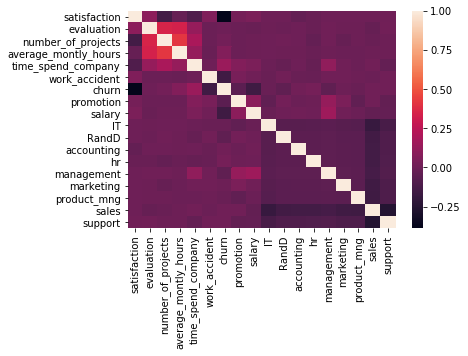

                      satisfaction  evaluation  number_of_projects  \
satisfaction              1.000000    0.105021           -0.142970   
evaluation                0.105021    1.000000            0.349333   
number_of_projects       -0.142970    0.349333            1.000000   
average_montly_hours     -0.020048    0.339742            0.417211   
time_spend_company       -0.100866    0.131591            0.196786   
work_accident             0.058697   -0.007104           -0.004741   
churn                    -0.388375    0.006567            0.023787   
promotion                 0.025605   -0.008684           -0.006064   
salary                    0.050022   -0.013002           -0.001803   
IT                        0.006373    0.001269            0.003287   
RandD                     0.006615   -0.005471            0.009703   
accounting               -0.028649    0.002193            0.004189   
hr                       -0.012841   -0.009645           -0.027356   
management          

In [11]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.show()
print(corr_matrix)

<br> Upon examining the Heat map, there is a clear negative correlation between satisfaction and employee churn. While this is a clear correlation, there are also negative correlations between work accident and salary.

## Building the Predictive Model: Decision Trees

My target variable is Churn:

In [12]:
y = df['churn']
y.head()
X = df.drop('churn', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.25)


clf = DecisionTreeClassifier(random_state= 42)
_ = clf.fit(X_train, y_train)


print('Accuracy on the train test {0:.2f}'.format(clf.score(X_train, y_train)*100 )+'%\n======================================')
print('Accuracy on the test set {0:.2f}'.format(clf.score(X_test, y_test)*100)+'%')

Accuracy on the train test 100.00%
Accuracy on the test set 97.33%


<br>For prediction purposes, this is not a bad percentage, I will still perform a cross fold validation to see how the model performs overall with different data. <br>




## Tuning the Classifier:

Limiting the tree depth and samples

In [28]:
clf_d5   = DecisionTreeClassifier(max_depth=5, random_state= 42)
clf_s100 = DecisionTreeClassifier(min_samples_leaf=100, random_state=42)
clf_comb = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state = 42)

clf_d5.fit(X_train, y_train)
print('Limited Depth Accuracy on the train test {0:.2f}'.format(clf_d5.score(X_train, y_train)*100 )+'%')
print('Limited Depth Accuracy on the test set {0:.2f}'.format(clf_d5.score(X_test, y_test)*100)+'%\n================================================')

clf_s100.fit(X_train, y_train)
print('Limited Sample Accuracy on the train test {0:.2f}'.format(clf_s100.score(X_train, y_train)*100 )+'%')
print('Limited Sample Accuracy on the test set {0:.2f}'.format(clf_s100.score(X_test, y_test)*100)+'%\n================================================')

clf_comb.fit(X_train, y_train)
print('Combined Limit Accuracy on the train test {0:.2f}'.format(clf_comb.score(X_train, y_train)*100 )+'%')
print('Combined Limit Accuracy on the test set {0:.2f}'.format(clf_comb.score(X_test, y_test)*100)+'%')

Limited Depth Accuracy on the train test 97.69%
Limited Depth Accuracy on the test set 97.12%
Limited Sample Accuracy on the train test 96.58%
Limited Sample Accuracy on the test set 96.13%
Combined Limit Accuracy on the train test 97.02%
Combined Limit Accuracy on the test set 96.40%


<br>Looking at the confusion matrix and recall/precision for the three different models:




In [17]:
#First Classifer: 
y_pred1 = clf.predict(X_test)
print('Confusion Matrix for first classifer:\n ',confusion_matrix(y_test, y_pred1), '\n')
print('Recall score for first classifer: {:.2f}'.format(recall_score(y_test, y_pred1)*100)+'%')
print('Precision score for first classifer: {:.2f}'.format(precision_score(y_test,y_pred1)*100)+'%')
print('Auc Score for first classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred1)*100)+'%\n================================================\n')

#Second Classifier....Restriction on the max depth of the decision trees: 
y_pred2 = clf_d5.predict(X_test)
print('Confusion Matrix for second classifer:\n ',confusion_matrix(y_test, y_pred2), '\n')
print('Recall score for second classifer: {:.2f}'.format(recall_score(y_test, y_pred2)*100)+'%')
print('Precision score for second classifer: {:.2f}'.format(precision_score(y_test,y_pred2)*100)+'%')
print('Auc Score for second classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred2)*100)+'%\n================================================\n')

#Thid Classifer..... Restriction on the minimum number of samples: 
y_pred3 = clf_s100.predict(X_test)
print('Confusion Matrix for third classifer:\n ',confusion_matrix(y_test, y_pred3), '\n')
print('Recall score for third classifer: {:.2f}'.format(recall_score(y_test, y_pred3)*100)+'%')
print('Precision score for third classifer: {:.2f}'.format(precision_score(y_test,y_pred3)*100)+'%')
print('Auc Score for third classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred3)*100)+'%\n================================================\n')

Confusion Matrix for first classifer:
  [[2787   66]
 [  34  863]] 

Recall score for first classifer: 96.21%
Precision score for first classifer: 92.90%
Auc Score for first classifier: 96.95%

Confusion Matrix for second classifer:
  [[2814   39]
 [  69  828]] 

Recall score for second classifer: 92.31%
Precision score for second classifer: 95.50%
Auc Score for second classifier: 95.47%

Confusion Matrix for third classifer:
  [[2792   61]
 [  84  813]] 

Recall score for third classifer: 90.64%
Precision score for third classifer: 93.02%
Auc Score for third classifier: 94.25%



# Metric Evaluation: <br>
Evaluating the above metrics, for the first classifer, we can see that we have captured 96.21% of all the people who are churning, but have only correctly classified 92% of the people who are churning in the model. However, looking at the AUC score, we can see that 96.5% of the true cases have been correctly  classified. We have correctly classified 96.5% of the employees who are leaving, and staying with the company.<br><br>When examining the following models with for the restrictions placed, second classifer(Max_depth restriction), third classifer(Minimum samples), we can see that they don't quite add up in terms of correctly classifying true cases in both leaving and staying the company. (Low auc scores) However, they do provide a better prediction for those who are churning from the company.<br><br>Looking at these scores, I will continue to develop the tree with the depth restriction, if we recall the original percentage evaluation 76% to 24%, this indicates a large class imbalance, which could result in a lower auc score. In other words, the model is more correctly identifying those who stayed are more influential on our model. So I will balance the classes.

In [18]:
clf_b = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state = 42)

clf_b.fit(X_train,y_train)
y_pred_b = clf_b.predict(X_test)

print('Accuracy on the train test {0:.2f}'.format(clf_b.score(X_train, y_train)*100 )+'%')
print('Accuracy on the test set {0:.2f}'.format(clf_b.score(X_test, y_test)*100)+'%\n')
print('Confusion Matrix for balanced classifer:\n ',confusion_matrix(y_test, y_pred_b), '\n')
print('Recall score for balanced classifer: {:.2f}'.format(recall_score(y_test, y_pred_b)*100)+'%')
print('Precision score for balanced classifer: {:.2f}'.format(precision_score(y_test,y_pred_b)*100)+'%')
print('Auc Score for balanced classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred_b)*100)+'%\n================================================\n')


Accuracy on the train test 97.89%
Accuracy on the test set 97.39%

Confusion Matrix for balanced classifer:
  [[2814   39]
 [  59  838]] 

Recall score for balanced classifer: 93.42%
Precision score for balanced classifer: 95.55%
Auc Score for balanced classifier: 96.03%



## HyperParameter Tuning: <br>
I will use GridSearchCV to estimate the best parameters for my model and select parameters I believe will not lead to overfitting the data while also providing the best scores in accurately predicting the employees who will churn and who will Stay(auc score)

In [19]:
clf=DecisionTreeClassifier(random_state=42,class_weight='balanced')

depths        = [i for i in (range(5,26,1))]
sample_leaves = [i for i in (range(50,525,50))]

params = {'max_depth':depths, 'min_samples_leaf':sample_leaves}

parameter_search = GridSearchCV(clf, param_grid=params, scoring = 'roc_auc', cv = 5)
_=parameter_search.fit(X_train,y_train)
print('Best parameters across 5 fold Cross Validation: ', parameter_search.best_params_)
print('Best paremter scores across 5 fold Cross Validation: {:.2f}'.format(parameter_search.best_score_*100)+'%')

Best parameters across 5 fold Cross Validation:  {'max_depth': 13, 'min_samples_leaf': 50}
Best paremter scores across 5 fold Cross Validation: 98.34%


# Evaluation: 
<br>It looks like the best parameters available for this model are a max_depth of 16, and a minimum sample leaf of 25. It scored an average score for AUC as a 98.40% across 5 folds.

In [20]:
clf_best = DecisionTreeClassifier(max_depth = 13, min_samples_leaf=50, random_state = 42, class_weight='balanced')

clf_best.fit(X_train,y_train)
y_pred_best = clf_best.predict(X_test)

print('Accuracy on the train test {0:.2f}'.format(clf_best.score(X_train, y_train)*100 )+'%')
print('Accuracy on the test set {0:.2f}'.format(clf_best.score(X_test, y_test)*100)+'%\n')
print('Confusion Matrix for balanced classifer:\n ',confusion_matrix(y_test, y_pred_best), '\n')
print('Recall score for balanced classifer: {:.2f}'.format(recall_score(y_test, y_pred_best)*100)+'%')
print('Precision score for balanced classifer: {:.2f}'.format(precision_score(y_test,y_pred_best)*100)+'%')
print('Auc Score for balanced classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred_best)*100)+'%\n================================================\n')

Accuracy on the train test 96.93%
Accuracy on the test set 96.56%

Confusion Matrix for balanced classifer:
  [[2801   52]
 [  77  820]] 

Recall score for balanced classifer: 91.42%
Precision score for balanced classifer: 94.04%
Auc Score for balanced classifier: 94.80%



# Evaluating Important features of a model to increase computational efficiency and increase interpretability:

In [21]:
feature_importances = clf_best.feature_importances_

feat_list = list(X)

features_df = pd.DataFrame(index=feat_list, data = feature_importances, columns = ['Importance'])

print('DataFrame of Features before importance sort:\n====================================\n ', features_df.head())
features_df = features_df.sort_values(by='Importance', ascending=False)
print('DataFrame of Features after importance sort: \n====================================\n', features_df.head())

DataFrame of Features before importance sort:
                        Importance
satisfaction            0.476645
evaluation              0.097060
number_of_projects      0.014526
average_montly_hours    0.042649
time_spend_company      0.365949
DataFrame of Features after importance sort: 
                       Importance
satisfaction            0.476645
time_spend_company      0.365949
evaluation              0.097060
average_montly_hours    0.042649
number_of_projects      0.014526


<br>==================================================<br>
It looks like the two most important features in terms of prediction are satisfaction, and evaluation of the employee: 
<br>==================================================<br>

In [22]:
imp_features = features_df[features_df['Importance'] >= 0.01]
print('Amount of features before filtering: \n',len(features_df))
print('Amount of features after filtering: \n', len(imp_features))
important_features = imp_features.index  

X_importance_train = X_train[important_features]
X_importance_test  = X_test[important_features]

Amount of features before filtering: 
 17
Amount of features after filtering: 
 5


## Training and evaluating the new model based off of selected important features and the optimized parameters from the last section:


In [23]:
clf_best2 = DecisionTreeClassifier(max_depth = 13, min_samples_leaf=50, random_state = 42, class_weight='balanced')

clf_best2.fit(X_importance_train,y_train)
y_pred_best2 = clf_best2.predict(X_importance_test)

print('Accuracy on the train test {0:.2f}'.format(clf_best2.score(X_importance_train, y_train)*100 )+'%')
print('Accuracy on the test set {0:.2f}'.format(clf_best2.score(X_importance_test, y_test)*100)+'%\n')
print('Confusion Matrix for balanced classifer:\n ',confusion_matrix(y_test, y_pred_best2), '\n')
print('Recall score for balanced classifer: {:.2f}'.format(recall_score(y_test, y_pred_best2)*100)+'%')
print('Precision score for balanced classifer: {:.2f}'.format(precision_score(y_test,y_pred_best2)*100)+'%')
print('Auc Score for balanced classifier: {:.2f}'.format(roc_auc_score(y_test, y_pred_best2)*100)+'%\n================================================\n')

Accuracy on the train test 96.93%
Accuracy on the test set 96.56%

Confusion Matrix for balanced classifer:
  [[2801   52]
 [  77  820]] 

Recall score for balanced classifer: 91.42%
Precision score for balanced classifer: 94.04%
Auc Score for balanced classifier: 94.80%



## Visualization:

In [24]:
X_g = X[important_features]

clf_best2.fit(X_importance_train, y_train)


export_graphviz(clf_best, out_file = 'tees.dot', filled = True, rounded = True, feature_names=X.columns)



dot_data = export_graphviz(clf_best2,
                                feature_names=X_g.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')


True

## Test Run:

In [98]:
prediction_map = {
    0:'Stay',
    1:'Churn'
    
}

counter = 1
while counter < 6:
    
    print(len(y_test))
    stay   = []
    churn  = []

    for i in range(3750):
        random_sample_with_replacement = X_importance_test.sample(n=1)
        array=clf_best2.predict(random_sample_with_replacement)
        #print(array)
        outcome = prediction_map[array[0]]
        #print(prediction_map[array[0]])
        if outcome == 'Stay':
            stay.append(outcome)
        else:
            churn.append(outcome)
        
    stay_test      = []
    churn_test     = []

    for i in y_test:
        if i == 1:
            churn_test.append(i)
        else:
            stay_test.append(i)

    print('Test', str(counter)+':\n') 
    print('Churn in the Stay prediction list:',('Churn' in stay))
    print('Stay in the Churn prediction list:',('Stay' in churn))
    print('\n')
    print('Churn in the Stay real test data list:',(1 in stay_test))
    print('Stay in the Churn real test data list:',(0 in churn_test))
    print('\n')
    print('Percentage of employees who stay in prediction {:.2f}'.format(len(churn)/(len(churn)+len(stay)))+'%')
    print('Percentage of employees who stay in actual test data {:.2f}'.format(len(churn_test)/(len(churn_test)+len(stay_test)))+'%')
    print('\n============================================================')
    counter +=1

3750
Test 1:

Churn in the Stay prediction list: False
Stay in the Churn prediction list: False


Churn in the Stay real test data list: False
Stay in the Churn real test data list: False


Percentage of employees who stay in prediction 0.23%
Percentage of employees who stay in actual test data 0.24%

3750
Test 2:

Churn in the Stay prediction list: False
Stay in the Churn prediction list: False


Churn in the Stay real test data list: False
Stay in the Churn real test data list: False


Percentage of employees who stay in prediction 0.22%
Percentage of employees who stay in actual test data 0.24%

3750
Test 3:

Churn in the Stay prediction list: False
Stay in the Churn prediction list: False


Churn in the Stay real test data list: False
Stay in the Churn real test data list: False


Percentage of employees who stay in prediction 0.24%
Percentage of employees who stay in actual test data 0.24%

3750
Test 4:

Churn in the Stay prediction list: False
Stay in the Churn prediction list: F

======================================================================<br>
After running three test, randomly sampling with replacement from the y_test split data, we can see that the predictor accurately within 1% of predicting whether the employee will churn based off of the X_test data. What the above test does, is loop through 3750(length of y_test) randomly drawn from the y_test data and appends the classification to a set of lists depending on the classification. The same is done for the y_test(actual values). The percentage of employees churned out of all samples are calculated and then compared with one another as displayed. The compositions are within 1 percentage of eachother.